1) Read the images and generate the train and test dataset (10 points)

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [2]:
TRAin_DATA_FOLDER= "train"

In [3]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        classes.append(class_label)

In [4]:
len(images)

4179

In [5]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [6]:
images = [resize_images(img) for img in images]

In [7]:
images[0].shape

(256, 256, 3)

In [8]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4179, 256, 256, 3)
classes shape:  (4179,)
number of Common Chickweed images is  -> 261
number of Sugar beet images is  -> 385
number of Charlock images is  -> 390
number of Small-flowered Cranesbill images is  -> 496
number of Loose Silky-bent images is  -> 654
number of Black-grass images is  -> 263
number of Scentless Mayweed images is  -> 516
number of Shepherds Purse images is  -> 231
number of Cleavers images is  -> 287
number of Maize images is  -> 221
number of Fat Hen images is  -> 475


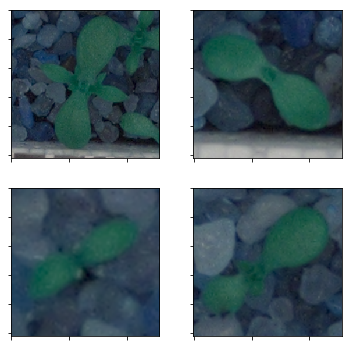

In [9]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

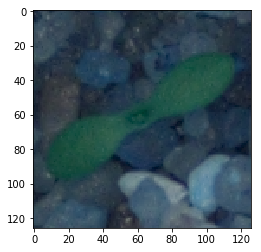

In [10]:
img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")
plt.imshow(img)

In [11]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [12]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Divide the data set into Train and validation data sets

In [13]:
#Creating train test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_train.shape

(2925, 256, 256, 3)

In [14]:
#Creating validation set
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [15]:
print(X_test.shape)
print(X_val.shape)

(627, 256, 256, 3)
(627, 256, 256, 3)


3) Initialize & build the model (20 points)

In [16]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = 3

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(11, activation = "softmax"))
model.summary()

Using TensorFlow backend.
W0927 00:49:23.298723  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 00:49:23.698410  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 00:49:23.817510  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 00:49:23.998505  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0927 00:49:23.998505  8828 deprecation_wrapper.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (3, 256, 256, 32)         2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (3, 256, 256, 32)         25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (3, 128, 128, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (3, 128, 128, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (3, 128, 128, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (3, 128, 128, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (3, 64, 64, 64)           0         
__________

4) Optimize the model (16 points)

In [17]:
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

W0927 00:49:24.228837  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 00:49:24.239768  8828 deprecation_wrapper.py:119] From C:\Users\Public\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



5) Predict the accuracy for both train and validation data (14 points)

In [18]:
model.fit(X_train, y_train, epochs = 50, validation_data = (X_val,Y_val),batch_size = batch_size)

W0927 00:49:25.072434  8828 deprecation.py:323] From C:\Users\Public\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2925 samples, validate on 627 samples
Epoch 1/50
2925/2925 [==============================] - 302s 103ms/step - loss: 14.2481 - acc: 0.1152 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 2/50
2925/2925 [==============================] - 195s 67ms/step - loss: 14.2061 - acc: 0.1186 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 3/50
2925/2925 [==============================] - 194s 66ms/step - loss: 14.2060 - acc: 0.1186 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 4/50
2925/2925 [==============================] - 194s 66ms/step - loss: 14.2060 - acc: 0.1186 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 5/50
2925/2925 [==============================] - 194s 66ms/step - loss: 14.2051 - acc: 0.1186 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 6/50
2925/2925 [==============================] - 194s 66ms/step - loss: 14.2060 - acc: 0.1186 - val_loss: 14.3443 - val_acc: 0.1100
Epoch 7/50
2925/2925 [==============================] - 194s 66ms/step - loss: 14.2005 - acc: 0.1190 - val_loss: 14.34

In [19]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 14.061560144074607
Test accuracy: 0.12759170656284077
